# Assignment 3 — Lars van den Heuvel & Lena van Leeuwen 
### *EV Adoption, Coordination, and Policy Intervention*

---

**Course:** Model Based Decisions (2025) — *MSc Complex Systems & Policy*  
**Lecturer:** Michael Lees  

---


In [21]:

from __future__ import annotations
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np
import random
from typing import Iterable, List, Dict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional


## Building the model

In [22]:
####################################
# Strategy selection helpers
#
# We provide two different ways agents can choose their strategy:
# - `choose_strategy_imitate`: choose strategy of the highest-payoff neighbour (including self).
# - `choose_strategy_logit`: choose strategy using logit / softmax choice.
#
####################################
def choose_strategy_imitate(agent, neighbors):
    """Choose strategy of the highest-payoff neighbour (including self)."""
    candidates = neighbors + [agent]
    best = max(candidates, key=lambda a: a.payoff)
    return best.strategy

def choose_strategy_logit(agent, neighbors, a_I, b, tau):
    """Choose strategy using logit / softmax choice.

    Parameters
    - agent: the agent choosing a strategy
    - neighbors: list of neighbour agents
    - a_I: effective coordination payoff given current infrastructure
    - b: defection payoff
    - tau: temperature parameter for softmax
    """
    # compute expected payoffs for C and D
    pi_C = 0.0
    pi_D = 0.0
    for other in neighbors:
        s_j = other.strategy
        if s_j == "C":
            pi_C += a_I
            pi_D += b
        else:
            pi_C += 0.0
            pi_D += b

    # softmax choice
    denom = np.exp(pi_C / tau) + np.exp(pi_D / tau)
    P_C = np.exp(pi_C / tau) / denom if denom > 0 else 0.5
    return "C" if agent.model.random.random() < P_C else "D"



In [23]:
class EVAgent(Agent):
    """Agent for EV Stag Hunt model (SimultaneousActivation-friendly).

    - step(): compute payoff AND decide next_strategy (do NOT commit)
    - advance(): commit next_strategy -> strategy
    """

    def __init__(self, unique_id, model, init_strategy="D"):
        super().__init__(unique_id, model)
        self.strategy = init_strategy
        self.payoff = 0.0
        self.next_strategy = init_strategy

    def _get_neighbor_agents(self):
        """Return list of agent objects that are neighbors on the network grid."""
        neighbors = []
        # self.pos is the node id in NetworkGrid
        for nbr in self.model.G.neighbors(self.pos):
            neighbors.extend(self.model.grid.get_cell_list_contents([nbr]))
        return neighbors

    def step(self):
        """Compute payoff from neighbors and choose next_strategy (but do NOT commit)."""
        I = self.model.infrastructure
        
        
        a0 = self.model.current_a0    
        
        
        beta_I = self.model.beta_I
        b = self.model.b
        a_I = a0 + beta_I * I        
        neighbor_agents = self._get_neighbor_agents()

        # If no neighbors: no interactions, keep payoff 0 and keep current strategy
        if not neighbor_agents:
            self.payoff = 0.0
            self.next_strategy = self.strategy
            return

        # Compute payoff (sum over pairwise interactions)
        payoff = 0.0
        for other in neighbor_agents:
            s_i = self.strategy
            s_j = other.strategy
            if s_i == "C" and s_j == "C":
                payoff += a_I
            elif s_i == "C" and s_j == "D":
                payoff += 0.0
            elif s_i == "D" and s_j == "C":
                payoff += b
            else:  # D vs D
                payoff += b
        self.payoff = payoff

        # Decide next strategy (do NOT assign to self.strategy here)
        func = getattr(self.model, "strategy_choice_func", "imitate")
        if func == "imitate":
            # expected signature: choose_strategy_imitate(agent, neighbor_agents) -> "C" or "D"
            self.next_strategy = choose_strategy_imitate(self, neighbor_agents)
        elif func == "logit":
            tau = getattr(self.model, "tau", 1.0)
            # expected signature: choose_strategy_logit(agent, neighbor_agents, a_I, b, tau)
            self.next_strategy = choose_strategy_logit(self, neighbor_agents, a_I, b, tau)
        else:
            raise ValueError(f"Unknown strategy choice function: {func}")

    def advance(self):
        """Commit the previously chosen next_strategy (synchronous update)."""
        # simply commit choice (no recomputation)
        self.strategy = self.next_strategy


In [24]:
 
    ####################################
    # Model class
    #
    # The EVStagHuntModel class implements the Mesa model for EV Stag Hunt on a network.
    #
    # Parameters
    # - initial_ev: number of initial EV nodes
    # - a0: base payoff for EV adoption
    # - beta_I: payoff enhancement factor for EV adoption
    # - b: payoff for ICE defection
    # - g_I: infrastructure growth rate
    # - I0: initial infrastructure level
    # - seed: random seed for reproducibility
    # - network_type: type of network to generate ("random" or "BA")
    # - n_nodes: number of nodes in the network
    # - p: probability of edge creation in random network
    # - m: number of edges to attach to new node in BA network
    # - collect: whether to collect agent and model-level data
    # - strategy_choice_func: strategy selection function ("imitate" or "logit")
    # - tau: temperature parameter for softmax choice (only used with "logit")
    ####################################
#
class EVStagHuntModel(Model):
    """Mesa model for EV Stag Hunt on a network."""

    def __init__(
        self,
        X0_frac=0.4,
        ratio=2.3,
        T=100,
        a0=2.0,
        beta_I=2.0,
        b=1.0,
        tol=1e-3,
        patience=10,
        g_I=0.1,
        I0=0.05,
        seed=None,
        network_type="random",
        n_nodes=100,
        p=0.05,
        m=2,
        collect=True,
        strategy_choice_func: str = "imitate",
        tau: float = 1.0,
        graph=None,
        subsidy_a0_boost: float = 0.0, 
        subsidy_start_t: int = 0,
        subsidy_end_t: int = 0,
    ):
        super().__init__(seed=seed)

       
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

       
        if graph is not None:
            self.G = graph
        else:
            if network_type == "BA":
                self.G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
            elif network_type == "WS":
                self.G = nx.watts_strogatz_graph(n_nodes, k, p=p, seed=seed)
            else:
                self.G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
            
        self.grid = NetworkGrid(self.G)
        self.schedule = SimultaneousActivation(self)

        # parameters
        self.a0 = a0
        self.beta_I = beta_I
        self.b = b
        self.g_I = g_I
        self.infrastructure = I0
        self.step_count = 0
        self.strategy_choice_func = strategy_choice_func
        self.tau = tau
        self.T = T
        self.base_a0 = a0 
        self.subsidy_a0_boost = subsidy_a0_boost
        self.subsidy_start_t = subsidy_start_t
        self.subsidy_end_t = subsidy_end_t
        self.current_a0 = a0

        # initialize node attribute for agent reference
        for n in sorted(self.G.nodes()):
            self.G.nodes[n]["agent"] = []


        total_nodes = n_nodes if graph is None else graph.number_of_nodes()
        initial_ev = int(X0_frac * total_nodes)
        k_ev = max(0, min(initial_ev, total_nodes))
        ev_nodes = set(self.random.sample(list(self.G.nodes), k_ev))

        # create one agent per node
        uid = 0
        for node in sorted(self.G.nodes()):
            init_strategy = "C" if node in ev_nodes else "D"
            agent = EVAgent(uid, self, init_strategy)
            uid += 1
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = None
        if collect:
            self.datacollector = DataCollector(
                model_reporters={
                    "X": self.get_adoption_fraction,
                    "I": lambda m: m.infrastructure,
                },
                agent_reporters={"strategy": "strategy", "payoff": "payoff"},
            )

    def get_adoption_fraction(self):
        agents = self.schedule.agents
        if not agents:
            return 0.0
        return sum(1 for a in agents if a.strategy == "C") / len(agents)

    def calculate_current_a0(self, current_time):
        is_intervention_active = (
            current_time >= self.subsidy_start_t 
            and current_time < self.subsidy_end_t
        )
        if is_intervention_active:
            return self.base_a0 + self.subsidy_a0_boost
        else:
            return self.base_a0
    
    # ####################
    # Model step function
    #
    # The step function advances the model by one time step.
    # It first advances all agents, then computes the adoption fraction and infrastructure level.
    # The infrastructure level is updated based on the adoption fraction and the infrastructure growth rate.
    # The updated infrastructure level is clipped to the interval [0, 1].
    # Finally, if data collection is enabled, the model and agent data are collected.
    #######################
    
    def step(self):
        self.current_a0 = self.calculate_current_a0(self.step_count)
        self.schedule.step() # advance all agents

        X = self.get_adoption_fraction() # compute adoption fraction after all agents have advanced
        I = self.infrastructure # infrastructure level before this step
        dI = self.g_I * (X - I) # infrastructure growth rate, impacted by adoption fraction
        self.infrastructure = float(min(1.0, max(0.0, I + dI))) # clip infrastructure level to [0, 1]
        
        if self.datacollector is not None:
            self.datacollector.collect(self) # collect data at the end of each step
            
        self.step_count += 1 # increment step count after data collection

In [25]:

#########################
#
# Set initial adopters
# 
# Parameters
# - model: the EVStagHuntModel instance
# - X0_frac: fraction of agents to initially choose EV adoption
# - method: method to choose initial adopters ("random" or "degree")
# - seed: random seed for reproducibility
# - high: whether to choose high or low degree nodes for "degree" method
###########################
def set_initial_adopters(model, X0_frac, method="random", seed=None, high=True):
    """Set a fraction of agents to EV adopters using different heuristics."""
    rng = np.random.default_rng(seed)
    agents = model.schedule.agents
    n = len(agents)
    k = int(round(X0_frac * n))

    for a in agents:
        a.strategy = "D"

    if k <= 0:
        return

    if method == "random":
        idx = rng.choice(n, size=k, replace=False)
        for i in idx:
            agents[i].strategy = "C"
        return

    if method == "degree":
        deg = dict(model.G.degree())
        ordered_nodes = sorted(deg.keys(), key=lambda u: deg[u], reverse=high)
        chosen = set(ordered_nodes[:k])
        for a in agents:
            if a.pos in chosen:
                a.strategy = "C"
        return

    raise ValueError(f"Unknown method: {method}")




## Part 1. Baseline system analysis

Phase plot for analysing ratio effect 

In [15]:
# -----------------------------
# Ratio sweep helpers (computation-only)
# -----------------------------
#########################
#
# Run a single network trial
# 
# Parameters
# - X0_frac: fraction of agents to initially choose EV adoption
# - ratio: payoff ratio between EV and DC agents (a0 = ratio*b - beta_I*I0)
# - I0: initial infrastructure level
# - beta_I: cost of EV adoption relative to DC (beta_I*I0)
# - b: payoff of EV (b)
# - g_I: infrastructure growth rate (g_I)
# - T: number of time steps to run
# - network_type: type of network to generate ("random" or "BA")
# - n_nodes: number of nodes in the network
# - p: probability of edge creation in random network
# - m: number of edges to attach from a new node to existing nodes in BA network
# - seed: random seed for reproducibility
# - tol: tolerance for convergence check (default: 1e-3)
# - patience: number of steps to wait for convergence (default: 30)

def run_network_trial(
    X0_frac: float,
    ratio: float,
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.1,
    T: int = 200,
    network_type: str = "random",
    n_nodes: int = 200,
    p: float = 0.05,
    m: int = 2,
    seed: int = 42,
    tol: float = 1e-3,
    patience: int = 30,
    collect: bool = False,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
) -> float:
    """Run a single realisation and return final adoption fraction.

    Preserves the intended initial payoff ratio via a0 = ratio*b - beta_I*I0.
    Includes basic stability-based early stopping.
    """
    initial_ev = int(round(X0_frac * n_nodes))
    a0 = ratio * b - beta_I * I0

    model = EVStagHuntModel(
        X0_frac=X0_frac,
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=collect,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    stable_steps = 0
    prev_X = None
    prev_I = None
    for _ in range(T):
        model.step()
        X = model.get_adoption_fraction()
        I = model.infrastructure
        if prev_X is not None and prev_I is not None:
            if abs(X - prev_X) < tol and abs(I - prev_I) < tol:
                stable_steps += 1
            else:
                stable_steps = 0
        prev_X, prev_I = X, I
        if X in (0.0, 1.0) and stable_steps >= 10:
            break
        if stable_steps >= patience:
            break

    return model.get_adoption_fraction()

In [16]:
#########################
#
# Compute heatmap row for a fixed ratio
# 
##########################
def _row_for_ratio_task(args: Dict) -> np.ndarray:
    """Top-level worker to compute one heatmap row for a fixed ratio.

    Returns an array of mean final adoption across provided X0_values.
    """
    ratio = args["ratio"]
    X0_values = args["X0_values"]
    I0 = args["I0"]
    beta_I = args["beta_I"]
    b = args["b"]
    g_I = args["g_I"]
    T = args["T"]
    network_type = args["network_type"]
    n_nodes = args["n_nodes"]
    p = args["p"]
    m = args["m"]
    batch_size = args["batch_size"]
    init_noise_I = args["init_noise_I"]
    strategy_choice_func = args["strategy_choice_func"]
    tau = args["tau"]

    row = np.empty(len(X0_values), dtype=float)
    for j, X0 in enumerate(X0_values):
        finals: List[float] = []
        for _ in range(batch_size):
            I0_j = float(np.clip(np.random.normal(loc=I0, scale=init_noise_I), 0.0, 1.0))
            seed_j = np.random.randint(0, 2**31 - 1)
            x_star = run_network_trial(
                X0_frac=X0,
                ratio=ratio,
                I0=I0_j,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                T=T,
                network_type=network_type,
                n_nodes=n_nodes,
                p=p,
                m=m,
                seed=seed_j,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            finals.append(x_star)
        row[j] = float(np.mean(finals))
    return row

    
#########################
#
# Compute heatmap matrix for phase sweep
# 
##########################
def phase_sweep_X0_vs_ratio(
    X0_values: Iterable[float],
    ratio_values: Iterable[float],
    *,
    I0: float = 0.05,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.10,
    T: int = 250,
    network_type: str = "random",
    n_nodes: int = 200,
    p: float = 0.05,
    m: int = 2,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    max_workers: int | None = None,
    backend: str = "thread",
) -> np.ndarray:
    """Compute a heatmap matrix of mean final adoption X* over (X0, ratio).

    Returns an array of shape (len(ratio_values), len(X0_values)) aligned with
    the provided orders. Rows correspond to ratios; columns to X0 values.
    """
    X0_values = list(X0_values)
    ratio_values = list(ratio_values)
    X_final = np.zeros((len(ratio_values), len(X0_values)), dtype=float)

    # Prepare tasks per ratio
    tasks: List[Dict] = []
    for ratio in ratio_values:
        tasks.append({
            "ratio": ratio,
            "X0_values": X0_values,
            "I0": I0,
            "beta_I": beta_I,
            "b": b,
            "g_I": g_I,
            "T": T,
            "network_type": network_type,
            "n_nodes": n_nodes,
            "p": p,
            "m": m,
            "batch_size": batch_size,
            "init_noise_I": init_noise_I,
            "strategy_choice_func": strategy_choice_func,
            "tau": tau,
        })

    if max_workers is None:
        try:
            max_workers = os.cpu_count() or 1
        except Exception:
            max_workers = 1

    Executor = ProcessPoolExecutor if backend == "process" and max_workers > 1 else ThreadPoolExecutor
    if max_workers > 1:
        with Executor(max_workers=max_workers) as ex:
            futures = [ex.submit(_row_for_ratio_task, args) for args in tasks]
            for i, fut in enumerate(futures):
                row = fut.result()
                X_final[i, :] = row
    else:
        for i, args in enumerate(tasks):
            row = _row_for_ratio_task(args)
            X_final[i, :] = row

    return X_final

In [17]:

def run_phase_plot_X0_vs_ratio_network(
    max_workers: int | None = None,
    backend: str = "thread",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 200,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    out_path: Optional[str] = None,
    seed=42
):
    """Produce a heatmap of X* over (X0, a_I/b) using core sweep helper.

    Saves a figure similar to the original model script and returns the path.
    """
    np.random.seed(42)

    # Defaults aligned with the original phase plot
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.10,
        "network_type": "random",
        "n_nodes": 200,
        "p": 0.05,
        "m": 2,
        "strategy_choice_func": "logit",
        "tau": 1.0,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_final,
        origin="lower",
        extent=[X0_values[0], X0_values[-1], ratio_values[0], ratio_values[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("a_I / b (initial payoff ratio)")
    plt.title("Network phase plot: X* over X0 and a_I/b")

    # Overlay initial threshold X = b/a_I => X = 1/ratio
    X_thresh = 1.0 / ratio_values
    X_thresh_clipped = np.clip(X_thresh, 0.0, 1.0)
    plt.plot(
        X_thresh_clipped,
        ratio_values,
        color="white",
        linestyle="--",
        linewidth=1.5,
        label="X = b / a_I (initial)",
    )

    plt.legend(loc="upper right")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_phase_plot.png")
    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path


In [ ]:

X0_values = np.linspace(0.0, 1.0, 21)
ratio_values = np.linspace(0.8, 3.5, 31)
scenario_kwargs = {
    "I0": 0.05,
    "beta_I": 2.0,
    "b": 1.0,
    "g_I": 0.10,
    "network_type": "random",
    "n_nodes": 200,  
}

phase_path = run_phase_plot_X0_vs_ratio_network(
    X0_values=X0_values,
    ratio_values=ratio_values,
    scenario_kwargs=scenario_kwargs,
    T=80,
    strategy_choice_func="logit",
    tau=1.0,
    max_workers=1,
    backend="thread",
    seed=42
)

print("Phase plot saved at:", phase_path)


Phase plot saved at: /Users/lenavanleeuwen/Desktop/Model-based-decision-making/Assignment_3_MBD/ev_phase_plot.png


Heatmap for analysing X0 and I0 effect

In [ ]:
def run_phase_plot_X0_vs_I0_fixed_ratio(
    model_class,
    ratio: float = 2.15,
    X0_values: np.ndarray | None = None,
    I0_values: np.ndarray | None = None,
    trials_per_point: int = 10,
    T: int = 200,
    n_nodes: int = 200,
    beta_I: float = 2.0,
    b: float = 1.0,
    g_I: float = 0.10,
    network_type: str = "random",
    p: float = 0.05,
    m: int = 2,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    seed: int = 42,
    out_path: str | None = None,
):
    """
    Phase plot of final adoption X* over (X0, I0) at fixed initial payoff ratio.
    a0 is recomputed per I0 to ensure identical starting incentives.
    """

    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if I0_values is None:
        I0_values = np.linspace(0.0, 1.0, 31)

    X_final = np.zeros((len(I0_values), len(X0_values)))

    for i, I0 in enumerate(I0_values):
       
        a0 = ratio * b - beta_I * I0

        for j, X0 in enumerate(X0_values):
            X_trials = []

            for trial in range(trials_per_point):
                trial_seed = seed + 10_000 * i + 100 * j + trial
                np.random.seed(trial_seed)

                model = model_class(
                    a0=a0,
                    beta_I=beta_I,
                    b=b,
                    g_I=g_I,
                    I0=I0,
                    X0_frac=X0,
                    n_nodes=n_nodes,
                    network_type=network_type,
                    p=p,
                    m=m,
                    collect=False,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                    seed=trial_seed,
                )

                for _ in range(T):
                    model.step()

                X_trials.append(model.get_adoption_fraction())

            X_final[i, j] = np.mean(X_trials)

    # ---- Plot ----
    plt.figure(figsize=(7, 4))
    im = plt.imshow(
        X_final,
        origin="lower",
        extent=[X0_values[0], X0_values[-1], I0_values[0], I0_values[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("Initial adoption X_0")
    plt.ylabel("Initial infrastructure I_0")
    plt.title(f"Phase diagram at fixed ratio = {ratio}")
    plt.grid(False)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "phase_X0_I0_fixed_ratio.png")

    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()

    return X_final, out_path



In [24]:
X_final, phase_path = run_phase_plot_X0_vs_I0_fixed_ratio(
    model_class=EVStagHuntModel,
    ratio=2.15,
    X0_values=np.linspace(0.0, 1.0, 31),
    I0_values=np.linspace(0.0, 1.0, 21),
    trials_per_point=10,
    T=80,
    n_nodes=200,
    beta_I=2.0,
    b=1.0,
    g_I=0.10,
    network_type="random",
    p=0.05,
    strategy_choice_func="logit",
    tau=1.0,
    seed=42,
)

print("Phase plot saved at:", phase_path)




Phase plot saved at: /Users/lenavanleeuwen/Desktop/Model-based-decision-making/Assignment_3_MBD/phase_X0_I0_fixed_ratio.png


## b1 sensitivity analysis

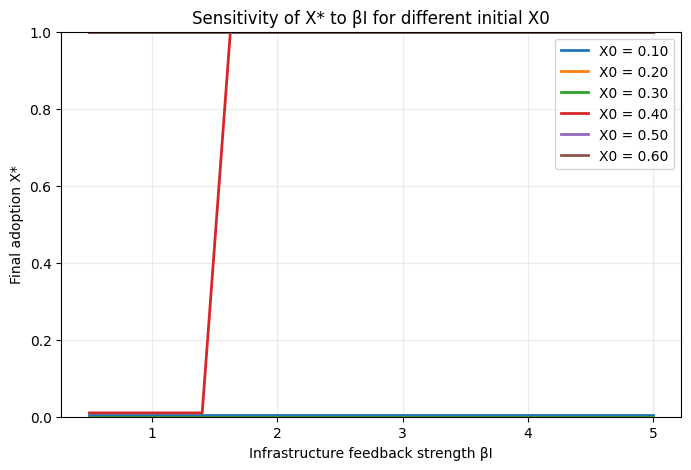

In [26]:
def run_multi_X0_betaI_sweep(
    model_class,
    X0_values = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60],
    beta_values = np.linspace(0.5, 5.0, 21),
    ratio = 2.3,
    I0 = 0.05,
    T = 200,
    n_nodes = 200,
    b = 1.0,
    g_I = 0.05,
    network_type = "random",
    strategy_choice_func = "logit",
    tau = 1.0,
    out_path = None,
    seed = 42
):
    """
    Generates a sensitivity plot:
    curves of X* vs βI for different initial adoption X0.
    """
    all_results = {}

    for X0_frac in X0_values:
        results = []

        for beta_I in beta_values:
            x0_frac = float(X0_frac)
            a0 = ratio * b - beta_I * I0  # maintain ratio at t=0

            model = model_class(
                X0_frac=X0_frac,
                a0=a0,
                beta_I=beta_I,
                b=b,
                g_I=g_I,
                I0=I0,
                n_nodes=n_nodes,
                network_type=network_type,
                collect=False,
                strategy_choice_func=strategy_choice_func,
                tau=tau,
                seed=seed
            )

            for t in range(T):
                model.step()

            results.append(model.get_adoption_fraction())

        all_results[X0_frac] = results

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8,5))

    for X0_frac, X_final_list in all_results.items():
        ax.plot(
            beta_values,
            X_final_list,
            lw=2,
            label=f"X0 = {X0_frac:.2f}"
        )

    ax.set_xlabel("Infrastructure feedback strength βI")
    ax.set_ylabel("Final adoption X*")
    ax.set_title("Sensitivity of X* to βI for different initial X0")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.25)
    ax.legend()

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "multi_betaI_sensitivity.png")

    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()

    return all_results, out_path

results, path = run_multi_X0_betaI_sweep(EVStagHuntModel)
print()

## Part 2. Network structure analysis

In [27]:
def cluster_formation(model):
    """
    Compute mean cluster size of adopter nodes using the external mapping
    model.node_mapping: agent -> node_id
    """
    adopter_nodes = [
        model.node_mapping[a]
        for a in model.schedule.agents
        if a.strategy == "C"
    ]

    if not adopter_nodes:
        return 0

    subgraph = model.G.subgraph(adopter_nodes)
    components = list(nx.connected_components(subgraph))

    if not components:
        return 0

    return np.mean([len(c) for c in components])



In [28]:
def analyze_topology(
    G,
    model_cls,
    base_kwargs,
    trials=10,
    T=100,
    threshold=0.8,
    network_offset=0,
    patience=5,
):
    speed_vals = []
    high_eq_vals = []
    cluster_vals = []
    tipping_vals = []

    base_seed = base_kwargs.get("seed", 42)

    for trial in range(trials):
        trial_seed = base_seed + network_offset * 1000 + trial

        kwargs = base_kwargs.copy()
        kwargs["seed"] = trial_seed

        # Full RNG sync
        np.random.seed(trial_seed)
        random.seed(trial_seed)

        # Initialize model with existing network
        model = model_cls(**kwargs, graph=G)
        model.node_mapping = {agent: node for agent, node in zip(model.schedule.agents, G.nodes())}



        # Simulate T steps with patience check
        history = []
        stable_count = 0
        for t in range(T):
            model.step()
            X = np.mean([1 if agent.strategy == "C" else 0 for agent in model.schedule.agents])
            history.append(X)

            if t > 0 and abs(history[-1] - history[-2]) < 1e-4:
                stable_count += 1
            else:
                stable_count = 0

            if stable_count >= patience:
                break

        # Speed
        speed = next((t + 1 for t, x in enumerate(history) if x >= threshold), None)
        if speed is not None:
            speed_vals.append(speed)

        # High equilibrium 
        high_eq_vals.append(int(history[-1] >= threshold))

        # Clusterformation
        try:
            clusters = cluster_formation(model)
            cluster_vals.append(clusters)
        except Exception as e:
            print(f"Warning: cluster computation failed in trial {trial}, error: {e}")
            cluster_vals.append(np.nan)

        # Tipping sensitivity
        tipping_vals.append(int(history[-1] >= threshold))

    return {
        "speed_mean": np.mean(speed_vals) if speed_vals else np.nan,
        "speed_sd": np.std(speed_vals) if speed_vals else np.nan,
        "high_eq_mean": np.mean(high_eq_vals) if high_eq_vals else np.nan,
        "high_eq_sd": np.std(high_eq_vals) if high_eq_vals else np.nan,
        "clusters_mean": np.nanmean(cluster_vals) if cluster_vals else np.nan,
        "clusters_sd": np.nanstd(cluster_vals) if cluster_vals else np.nan,
        "tipping_sensitivity": np.mean(tipping_vals) if tipping_vals else np.nan,
    }


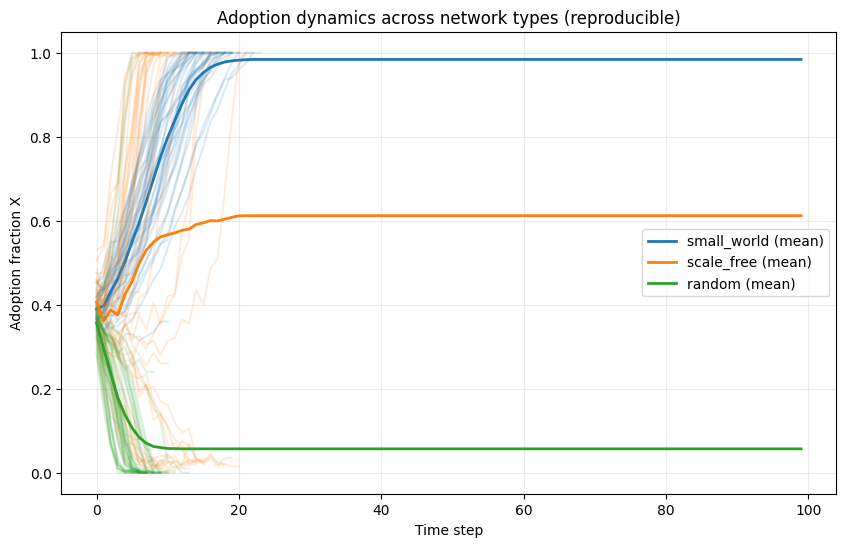

             speed_mean  speed_sd  high_eq_mean  high_eq_sd  clusters_mean  \
network                                                                      
small_world   11.307692  2.355069         0.975    0.156125     195.600000   
scale_free     8.347826  3.783358         0.575    0.494343     115.440903   
random         5.000000  0.000000         0.050    0.217945      10.210000   

             clusters_sd  tipping_sensitivity  
network                                        
small_world    27.477991                0.975  
scale_free     98.055029                0.575  
random         43.543655                0.050  


In [29]:
def run_network_analysis_with_curves_repro(model_cls, base_model_kwargs, trials=10, 
                                           grid_sizes=(10,10), n=200, 
                                           p_er=0.05, p_sw=0.1, k_sw=6, m_sf=3, 
                                           T=100, threshold=0.8):
    """
    Runs a network analysis and generates metrics and adoption curves. 
    The Random/Scale-Free and Small world network will be re-generated per trial so results are comparable with the subsidy-experiment.
    """
    results = {}
    curves = {}
    base_seed = 42

    network_types = ["small_world", "scale_free", "random"]

    for idx, net_type in enumerate(network_types):
        speed_vals = []
        high_eq_vals = []
        cluster_vals = []
        tipping_vals = []
        network_curves = []

        for trial_id in range(trials):
            trial_seed = base_seed + trial_id

            # Generate network per trial
            if net_type == "small_world":
                G = nx.watts_strogatz_graph(n, k_sw, p_sw, seed=trial_seed)
            elif net_type == "scale_free":
                G = nx.barabasi_albert_graph(n, m_sf, seed=trial_seed)
            elif net_type == "random":
                G = nx.erdos_renyi_graph(n, p_er, seed=trial_seed)
            else:
                raise ValueError(f"Onbekend netwerk type: {net_type}")

            kwargs = base_model_kwargs.copy()
            kwargs["seed"] = trial_seed
            kwargs["network_type"] = None  
            model = model_cls(**kwargs, graph=G)
            model.node_mapping = {agent: node for agent, node in zip(model.schedule.agents, G.nodes())}


            history = []
            for t in range(T):
                model.step()
                X = np.mean([1 if a.strategy == "C" else 0 for a in model.schedule.agents])
                history.append(X)
                if t > 5 and abs(history[-1] - history[-2]) < 1e-4:
                    break

            network_curves.append(history)

            # Metrics
            speed = next((t+1 for t, x in enumerate(history) if x >= threshold), None)
            if speed is not None:
                speed_vals.append(speed)
            high_eq_vals.append(int(history[-1] >= threshold))
            try:
                clusters = cluster_formation(model)
                cluster_vals.append(clusters)
            except:
                cluster_vals.append(np.nan)
            tipping_vals.append(int(history[-1] >= threshold))

        # Summarized metrics
        results[net_type] = {
            "speed_mean": np.mean(speed_vals) if speed_vals else np.nan,
            "speed_sd": np.std(speed_vals) if speed_vals else np.nan,
            "high_eq_mean": np.mean(high_eq_vals) if high_eq_vals else np.nan,
            "high_eq_sd": np.std(high_eq_vals) if high_eq_vals else np.nan,
            "clusters_mean": np.mean(cluster_vals) if cluster_vals else np.nan,
            "clusters_sd": np.std(cluster_vals) if cluster_vals else np.nan,
            "tipping_sensitivity": np.mean(tipping_vals) if tipping_vals else np.nan
        }
        curves[net_type] = network_curves

    # Metrics DataFrame
    df_metrics = pd.DataFrame(results).T
    df_metrics.index.name = "network"

    # Plot adoptioncurves
    plt.figure(figsize=(10,6))
    for net_name, all_histories in curves.items():
        for h in all_histories:
            plt.plot(h, color=f"C{list(network_types).index(net_name)}", alpha=0.15)
        avg_curve = np.mean([np.pad(h, (0,T-len(h)), 'edge') for h in all_histories], axis=0)
        plt.plot(avg_curve, lw=2, label=f"{net_name} (mean)")
    plt.xlabel("Time step")
    plt.ylabel("Adoption fraction X")
    plt.title("Adoption dynamics across network types (reproducible)")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

    return df_metrics, curves

ratio = 2.15
a0_val = ratio * 1.0 - 2.0 * 0.05  # b=1.0, beta_I=2.0, I0=0.05

params = {
    "X0_frac": 0.40,
    "I0": 0.05,
    "beta_I": 2.0,
    "b": 1.0,
    "g_I": 0.10,
    "a0": a0_val,
    "T": 100,
    "patience": 10,
    "collect": False,
    "strategy_choice_func": "logit",
    "tau": 1.0,
}

# Gebruik
metrics_df, curves_dict = run_network_analysis_with_curves_repro(EVStagHuntModel, params, trials=40, T=100)
print(metrics_df)


## Part 3: Policy experiment

In [30]:
def _default_plot_path(filename: str) -> str:
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    return os.path.join(plots_dir, filename)


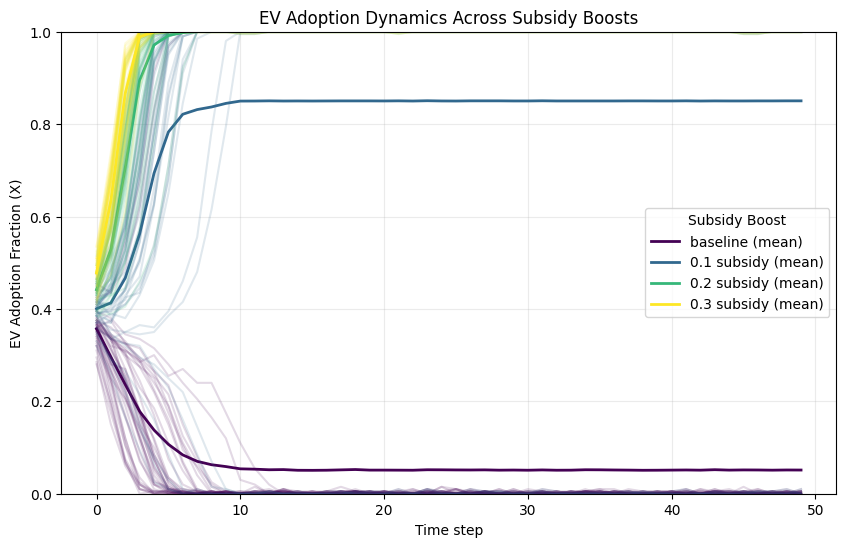

In [31]:
# TESTING DIFFERENT SUBSIDY BOOSTS
# --- Experiment runner ---
def run_intervention_comparison(n_trials=10, T=50, seed=42):
    np.random.seed(seed)
    data_records = []

    scenarios = {"baseline": 2.15, "0.1 subsidy": 2.25, "0.2 subsidy": 2.35, "0.3 subsidy": 2.45}

    for group_name, ratio in scenarios.items():
        for trial_id in range(n_trials):
            a0_val = ratio * 1.0 - 2.0 * 0.05  # b=1.0, beta_I=2.0, I0=0.05

            model = EVStagHuntModel(
                X0_frac=0.4,
                beta_I=2.0,
                b=1.0,
                g_I=0.1,
                I0=0.05,
                T=T,
                a0=a0_val,
                tol=1e-3,
                n_nodes=200,
                network_type="random",
                collect=False,
                strategy_choice_func="logit",
                tau=1,
                seed=seed + trial_id,
                p=0.05
            )

            for t in range(T):
                model.step()
                data_records.append({
                    "group": group_name,
                    "trial": trial_id,
                    "time": t,
                    "X": model.get_adoption_fraction()
                })

    return pd.DataFrame(data_records)

def plot_adoption_curves(traces_df, T=50):
    """
    Plot all individual adoption curves per subsidy boost. 
    """
    plt.figure(figsize=(10,6))

    def parse_boost(name):
        try:
            return float(name.split()[0])
        except:
            return -1 

    subsidy_groups = sorted(traces_df["group"].unique(), key=parse_boost)
    colors = plt.cm.viridis(np.linspace(0, 1, len(subsidy_groups)))

    for color, group_name in zip(colors, subsidy_groups):
        group_data = traces_df[traces_df["group"] == group_name]

        trials = group_data["trial"].unique()
        all_histories = []
        for trial in trials:
            trial_data = group_data[group_data["trial"] == trial].sort_values("time")
            all_histories.append(trial_data["X"].values)

        for h in all_histories:
            plt.plot(h, color=color, alpha=0.15)

        avg_curve = np.mean([np.pad(h, (0,T-len(h)), 'edge') for h in all_histories], axis=0)
        plt.plot(avg_curve, lw=2, color=color, label=f"{group_name} (mean)")

    plt.xlabel("Time step")
    plt.ylabel("EV Adoption Fraction (X)")
    plt.title("EV Adoption Dynamics Across Subsidy Boosts")
    plt.legend(title="Subsidy Boost")
    plt.ylim(0, 1)
    plt.grid(alpha=0.25)
    plt.show()


# --- Run experiment ---
traces_df = run_intervention_comparison(n_trials=40, T=50)
plot_adoption_curves(traces_df)


In [32]:
def generate_network(network_type, params, seed):
    """Generate a network based on seed and networktype"""
    n = params.get("n_nodes", 200)
    k_sw = params.get("k_sw", 6)
    p_sw = params.get("p_sw", 0.1)
    m_sf = params.get("m", 3)
    p_er = params.get("p", 0.05)

    if network_type == "small_world":
        G = nx.watts_strogatz_graph(n, k_sw, p_sw, seed=seed)
    elif network_type == "scale_free" or network_type == "BA":
        G = nx.barabasi_albert_graph(n, m_sf, seed=seed)
    elif network_type == "erdos_renyi" or network_type == "random":
        G = nx.erdos_renyi_graph(n, p_er, seed=seed)
    else:
        raise ValueError(f"Unknown network type {network_type}")
    return G

def run_timed_intervention_comparison_repro_independent_seeds(
    n_trials: int = 30, 
    T: int = 80, 
    base_ratio: float = 2.15, 
    subsidy_ratio_boost: float = 0.2,
    network_types: list[str] = ["random", "BA", "small_world"], 
    base_seed: int = 42
) -> pd.DataFrame:
    """
    Runs simulations for timed subsidies, with independendt seeding for network and scenario. This ensures all scenario's are visible with mean curves. 
    """
    print(f"--- Start Experiment: timed subsidies ({n_trials} trials per group per network) ---")
    
    data_records = []
    
    scenarios = {
        "Baseline":        {"start": 0,  "end": 0,    "ratio_boost": 0.0},
        "Early_T1_T20":    {"start": 1,  "end": 20,   "ratio_boost": subsidy_ratio_boost},
        "Mid_T30_T50":     {"start": 30, "end": 50,   "ratio_boost": subsidy_ratio_boost},
        "Late_T60_T80":    {"start": 60, "end": T,    "ratio_boost": subsidy_ratio_boost},
        "Constant_T1_T80": {"start": 1,  "end": T,    "ratio_boost": subsidy_ratio_boost},
    }

    params = {
        "X0_frac": 0.4,       
        "b": 1.0,             
        "beta_I": 2.0,
        "I0": 0.05,
        "g_I": 0.1,           
        "n_nodes": 200,
        "p": 0.05,
        "m": 3,
        "k_sw": 6,
        "p_sw": 0.1,
        "strategy_choice_func": "logit",
        "tau": 1.0           
    }

    base_a0 = base_ratio * params["b"] - params["beta_I"] * params["I0"]

    for network_type in network_types:
        print(f"\n--- Netwerk: {network_type.upper()} ---")
        for trial_id in range(n_trials):
            network_seed = base_seed + trial_id
            G = generate_network(network_type, params, network_seed)

            for group_name, scen_params in scenarios.items():
                model_seed = base_seed + 1000 + trial_id + hash(group_name) % 1000
                current_a0_boost = scen_params["ratio_boost"] * params["b"]

                model = EVStagHuntModel(
                    X0_frac=params["X0_frac"],
                    a0=base_a0, 
                    subsidy_a0_boost=current_a0_boost,
                    subsidy_start_t=scen_params["start"], 
                    subsidy_end_t=scen_params["end"], 
                    
                    beta_I=params["beta_I"],
                    b=params["b"],
                    g_I=params["g_I"],
                    I0=params["I0"],
                    T=T,
                    
                    graph=G,
                    
                    strategy_choice_func=params["strategy_choice_func"],
                    tau=params["tau"],
                    seed=model_seed
                )

                for t in range(T):
                    model.step()
                    data_records.append({
                        "group": group_name,
                        "trial": trial_id,
                        "network": network_type,
                        "trial_seed": network_seed,
                        "model_seed": model_seed,
                        "time": t,
                        "X": model.get_adoption_fraction()
                    })

    traces_df = pd.DataFrame(data_records)
    return traces_df

In [33]:

def plot_adoption_curves_all_networks_softcolors(traces_df, out_path="plots/adoption_curves_all_networks_soft.png", dpi=140):
    """
    Makes one figure with three subplots for all networks. Each subplot shows mean adoption X(t) per scenario.
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    networks = traces_df["network"].unique()
    groups_order = ["Baseline", "Early_T1_T20", "Mid_T30_T50", "Late_T60_T80", "Constant_T1_T80"]


    colors = ["#e69f9f", "#a6d96a", "#fdae61", "#66c2a5", "#9e91d1"]

    fig, axes = plt.subplots(1, len(networks), figsize=(6*len(networks), 5), sharey=True)

    if len(networks) == 1:
        axes = [axes]  

    for ax, network_type in zip(axes, networks):
        df_net = traces_df[traces_df["network"] == network_type]
        mean_traces = df_net.groupby(["group", "time"])["X"].mean().reset_index()

        for i, group_name in enumerate(groups_order):
            gdf = mean_traces[mean_traces["group"] == group_name]
            if gdf.empty:
                print(f"No data for group {group_name} in network {network_type}")
                continue
            ax.plot(gdf["time"], gdf["X"], label=group_name, color=colors[i], lw=2)

        ax.set_title(f"{network_type.upper()}")
        ax.set_xlabel("Time step")
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Adoptionfraction X(t)")
    axes[-1].legend(loc="lower right")  
    fig.suptitle("Adoption X(t) per scenario for different networks)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(out_path, dpi=dpi)
    plt.close(fig)
    print(f"Save combined plot: {out_path}")


In [34]:
#Run simulation
traces_df = run_timed_intervention_comparison_repro_independent_seeds(
    n_trials=30,                      
    T=80,                             
    subsidy_ratio_boost=0.2,         
    network_types=["random", "scale_free", "small_world"],  
    base_seed=42                       
)

plot_adoption_curves_all_networks_softcolors(traces_df)

--- Start Experiment: timed subsidies (30 trials per group per network) ---

--- Netwerk: RANDOM ---

--- Netwerk: SCALE_FREE ---

--- Netwerk: SMALL_WORLD ---
Save combined plot: plots/adoption_curves_all_networks_soft.png
